(dask-task-graph)=
# Task Graph 与数据切分

{numref}`get-started-dask-dataframe` 最后对 Dask DataFrame 的 Task Graph 进行了可视化。本节介绍 Dask 的 Task Graph 和数据切分机制。

## Task Graph 与数据切分

Dask 将大数据切分成可被很多个小数据，对于 Dask Array 来说，切分成了块（Chunk）；对于 Dask DataFrame 来说，切分成了分区（Partition）。虽然 Chunk 和 Partition 名词不同，但本质上都是数据的切分。

下面的例子模拟了这样的计算：一个 $10 \times 10$ 矩阵切分为 4 个 $5 \times 5$ 矩阵。

In [26]:
import dask.array as da
x = da.ones((10, 10), chunks=(5, 5))

y = x + x.T
y

dask.array<add, shape=(10, 10), dtype=float64, chunksize=(5, 5), chunktype=numpy.ndarray>

经过了数据切分后，共有 4 个 Chunk，Dask 对这 4 个 Chunk 分配了索引 Index，分别为：(0, 0)、(0, 1)、（1, 0）、(1, 1)。每个 Chunk 调用 NumPy 接口进行计算，必要时还需要对多个 Chunk 进行聚合操作。Dask 使用计算图把这些 Chunk 的计算组织起来。和很多大数据计算框架一样，Dask 的计算图是有向无环图（Directed Acyclic Graph，DAG），Dask 称之为 Task Graph，可以通过 `.visualize()` 方法将 Task Graph 可视化出来。下图给出了这个矩阵运算的 Task Graph。 

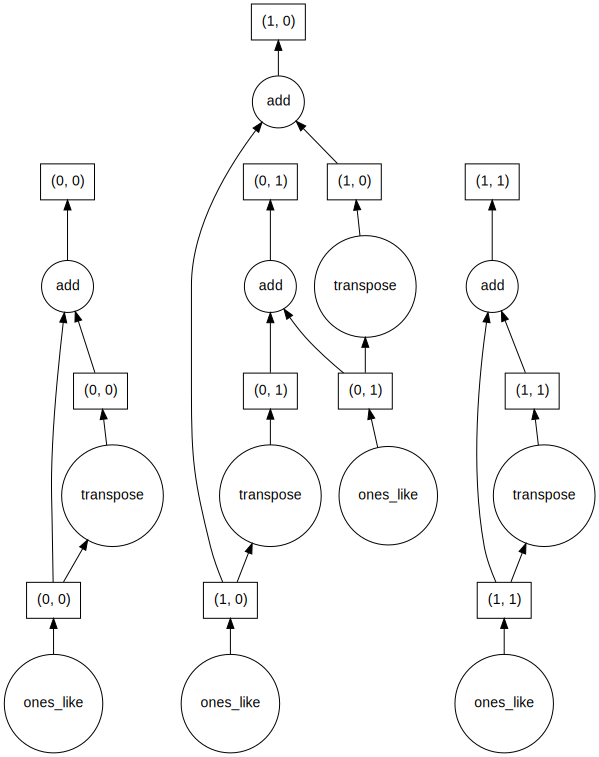

In [27]:
y.visualize(filename='../img/ch-dask/transpose.svg')

在这个 Task Graph 中，圆圈表示计算，比如 ones_like 代表 NumPy 的 `np.ones_like()` 方法，transpose 代表 NumPy 的 `np.transpose()` 方法；方块表示数据的占位符，表示经过了前一步计算得到的数据块。

Dask Scheduler 会生成 Task Graph，并将 Task Graph 中的各个具体的计算任务分发到 Dask Worker 上。

## 数据切分粒度

可以看到，数据切分的粒度影响了 Task Graph：

* 如果每个数据块很小，那么 Task Graph 将会很大
* 如果每个数据块很大，那么 Task Graph 将会很小

过大或者过小的数据块都不是最优解。

### 数据块过小

如果数据块过小，那么生成的 Task Graph 很大。据统计，Dask Scheduler 协调分发 Task Graph 中的一个计算任务平均需要 1 毫秒，如果 Task Graph 很大，Dask 将花费大量时间用在计算资源协调与分发上。

如果用一个比喻的话，Dask Scheduler 是包工头，Dask Worker 是建筑工人。现在要用很多块砖砌一堵墙，建筑工人将砖块搬到墙上，如果包工头在布置任务时，让每个建筑工人一次只搬一块砖，大量时间都花在了来回搬运上，实际上没有充分利用建筑工人的能力，而且包工头疲于指挥各个建筑工人。对于数据块过小的情况，一方面，Dask Worker 工作欠饱和；另一方面，Dask Scheduler 分发任务的负载也很重。当数据块过小时，Dask 会生成一个很大的 Task Graph，Dask 输出的日志中通常会带有一些提示。

### 数据块过大

数据块过大，则 Dask Worker 很容易内存耗尽（Out of Memory，OOM），因为所切分的数据块无法被单个 Dask Worker 所处理。Dask 遇到 OOM 时，会将部分数据卸载到（Spill）硬盘，如果 Spill 之后仍无法完成计算，Dask Worker 进程可能被重启，甚至反复重启。

## 设置正确的数据块大小

总之，在做数据块切分时，不应过大，也不应过小。
Dask 没有一个简单通用的设置，需要开发者根据自身数据的情况和 Dask 的仪表盘或日志来不断调整。

### 仪表盘

如 {numref}`dask-dashboard` 所示，Dask 仪表盘提供了计算任务运行时信息，需要根据仪表盘来调整数据分块。

```{figure} ../img/ch-dask/dask-dashboard.png
---
width: 800px
name: dask-dashboard
---
Dask 仪表盘
```

我们需要关注 Task Stream 栏，应该避免大量的空白或大量的红色。空白表示 Dask Worker 上没有任何任务，红色表示 Dask Worker 之间进行大量的数据交换。

{numref}`dask-good-partitions` 和 {numref}`dask-too-many-partitions` 是一个对比，两张图使用代码相同（{numref}`dask-read-write` 中的例子），但是使用的数据块大小不同。{numref}`dask-too-many-partitions` 中的数据块过小，Task Graph 过大，出现了大量的红色，时间没有用在计算上，而是浪费在数据交换等其他事情上。

```{figure} ../img/ch-dask/good-partitions.png
---
width: 600px
name: dask-good-partitions
---
正常的 Task Stream
```

```{figure} ../img/ch-dask/too-many-partitions.png
---
width: 600px
name: dask-too-many-partitions
---
每个 Partition 过小，导致 Task Graph 过大，Task 切分粒度过细，时间没有用在计算上，而是浪费在数据交换等其他事情上
```

内存方面，尽量不要出现橙色、灰色或者红色，出现灰色或红色时说明数据切分得太大，超出了 Dask Worker 的内存范围。{numref}`dask-memory` 展示了内存使用状态变化情况。

<table>
    <tr>
        <td>
            <div role="img" aria-label="blue square" style="color:rgba(0, 0, 255, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>内存数据在正常范围内</td>
    </tr>
    <tr>
        <td>
            <div role="img" aria-label="orange square" style="color:rgba(255, 165, 0, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>内存数据接近卸载的阈值</td>
    </tr>
    <tr>
        <td>
            <div role="img" aria-label="red square" style="color:rgba(255, 0, 0, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>某个 Dask Worker 暂停</td>
    </tr>
    <tr>
        <td>
            <div role="img" aria-label="grey square" style="color:rgba(128, 128, 128, 1); font-size: 25px ">&#9632;</div>
        </td>
        <td>内存数据卸载到硬盘上</td>
    </tr>
</table>

```{figure} ../img/ch-dask/dashboard-memory.gif
---
width: 600px
name: dask-memory
---
Dask 仪表盘展示了内存使用变化情况
```

### 设置数据块大小

Dask Array 和 Dask DataFrame 都提供了设置的方式。

可以在初始化是就设定每个数据块的大小：`x = da.ones((10, 10), chunks=(5, 5))`，`chunks` 用来设置每个数据块大小。也可以在程序运行过程中调整，比如 Dask Array 的 [`rechunk()`](https://docs.dask.org/en/latest/generated/dask.array.rechunk.html) 和 Dask DataFrame 的 [`repartition`](https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.repartition.html)。
